# **Permuted MNIST — Étude comparative d’agents MLP**
**Auteur :** Hugo Bouton et Erwan Ouabdesselam  
**Contexte :** ML-Arena – Permuted MNIST (CPU only, budget ~60 s/task)

## **1. Contexte et objectif**
L’objectif de ce travail est de développer, comprendre et comparer plusieurs modèles de réseaux de neurones adaptés au problème **Permuted MNIST**, un benchmark de *continual learning* où les images MNIST subissent des permutations aléatoires des pixels à chaque tâche.

Le défi principal réside dans le fait que chaque permutation détruit la structure spatiale locale de l’image :  
autrement dit, **les relations entre pixels voisins n’ont plus de sens**.  
Dans un contexte classique (MNIST non permuté), on utiliserait naturellement un réseau **convolutif (CNN)**,  
mais ici les convolutions deviennent inutiles car la topologie de l’image est totalement brouillée.

Nous avons donc concentré notre étude sur des **architectures MLP (Multi-Layer Perceptron)**,  
plus adaptées à ce type d’entrée vectorisée où chaque pixel est traité indépendamment.


**Contraintes du challenge**
Toutes les expérimentations ont été réalisées dans les conditions imposées par la plateforme **ML-Arena (Permuted MNIST)** :

### **Contraintes du challenge**
- **CPU-only (2 threads)** — aucune accélération GPU autorisée  
- **Mémoire limitée à 4 GB**  
- **Temps d’exécution par tâche ≈ 60 secondes** (hors instanciation du modèle)  

Ces contraintes excluent d’emblée l’utilisation de modèles lourds (CNN, Transformers) et ont guidé la conception de réseaux **légers, rapides et stables** à l’entraînement.


## **2. Démarche exploratoire**
Avant de converger vers les MLP, plusieurs types de modèles ont été explorés :

1. **Modèles linéaires (Logistic Regression, Ridge, SVM linéaire)**  
   → Résultats plafonnant à **~92–94 %** d’accuracy sur une seule permutation.  
   Ces modèles simples apprennent bien la distribution initiale mais généralisent mal  
   lorsque la permutation change (ils n’extraient aucune invariance utile).

2. **Petits réseaux à une seule couche cachée**  
   → Gain modéré (**~96–97 %**), mais incapacité à dépasser ce seuil sans surapprentissage.  
   Ces architectures capturent des interactions non linéaires,  
   mais leur profondeur limitée restreint leur capacité de généralisation.

3. **Réseaux convolutifs (CNN)**  
   → Abandonnés rapidement : les convolutions reposent sur la structure spatiale de l’image,  
   or celle-ci disparaît entièrement avec la permutation aléatoire des pixels.  
   L’usage d’un CNN dans ce contexte n’apporte aucun avantage structurel  
   et alourdit inutilement le calcul sous contraintes CPU.

Ces observations ont conduit à concentrer nos efforts sur une famille d’architectures  
**MLP pures**, entièrement connectées, flexibles et adaptées aux entrées aplaties (784 features).


## **3. Passage aux MLP et optimisation**
Une série d’expériences a ensuite permis d’identifier les architectures MLP les plus efficaces sous contrainte CPU :

- **Profondeur et largeur** :  
  Passage progressif de réseaux `(1024, 512)` à `(1536, 768)` puis `(2048, 1024)`  
  afin d’explorer le compromis entre capacité de représentation et temps d’entraînement.

- **Fonctions d’activation** :  
  Comparaison entre **ReLU** (simple, rapide) et **GELU** (plus lisse et stable).  
  Les meilleures performances sont obtenues avec **GELU** couplé à une **Layer Normalization**,  
  qui stabilise l’optimisation sous permutations aléatoires.

- **Régularisation** :  
  Utilisation du **Dropout** (0.05 à 0.15) et du **Label Smoothing** (0.05),  
  efficaces pour limiter la surconfiance et améliorer la robustesse inter-tâches.

- **Optimisation** :  
  Entraînement avec **AdamW**, 10 époques par tâche, budget temps limité à **~58 secondes**,  
  validation à chaque deux époques et arrêt anticipé (*early stopping*).

Les meilleures configurations atteignent des performances de l’ordre de **98.5 % d’accuracy moyenne**  
avec un **temps moyen de 20 à 30 secondes par tâche** sur CPU.


In [4]:
# ============================================================
# 0) Setup & contraintes (à exécuter en premier)
# ============================================================
import os, sys, time, json, csv
from pathlib import Path
import importlib

# --- Limites challenge : A APPELER AVANT numpy/torch/matplotlib ---
from permuted_mnist.limits_perf3 import apply_challenge_limits, print_limits
apply_challenge_limits(threads=2, forbid_gpu=True, ram_gb=4, show=True)
print_limits()

# --- Imports lourds APRÈS les limites ---
import numpy as np
import matplotlib.pyplot as plt
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

# --- Repro & sorties ---
SEED = 42
np.random.seed(SEED)

PRUNE_TIME_S = 60.0     # contrainte "plateforme" (~60 s task, init+train+pred inclus)
N_TASKS = 10            # nb de tâches par agent pour la comparaison
RUN_TAG = "cmp_v1"      # suffixe pour nommer les fichiers de sortie

ROOT = Path.cwd().parent           # si le notebook est dans permuted_mnist/notebooks/
OUT_DIR = ROOT / "experiments" / "benchmark_agents"
OUT_DIR.mkdir(parents=True, exist_ok=True)

[limits] OMP/BLAS threads=2 | CUDA_VISIBLE_DEVICES=-1
[limits] RLIMIT_AS: soft=8589934591GB hard=8589934591GB
[limits] OMP/BLAS threads=2 | CUDA_VISIBLE_DEVICES=-1
[limits] RLIMIT_AS: soft=8589934591GB hard=8589934591GB


In [5]:
# ============================================================
# 1) Déclarer les agents à COMPARER (déjà existants dans le repo)
#    - module: chemin du module Python (sans .py)
#    - cls   : nom de la classe (souvent "Agent")
#    - kwargs: arguments optionnels à passer au constructeur
# ============================================================
AGENTS = [
    {
        "name": "Bruce Wayne — fast (1536,768, p=0.05, ReLU)",
        "module": "permuted_mnist.agent.mlp4.agent_Bruce_Wayne",
        "cls": "Agent",
        "kwargs": {"output_dim": 10, "seed": SEED}
    },
    {
        "name": "Peter Parker — strong (2048,1024, GELU+LN, p=0.10)",
        "module": "permuted_mnist.agent_r1.agent_Peter_Parker",
        "cls": "Agent",
        "kwargs": {"output_dim": 10, "seed": SEED}
    },
    # 👉 ajoute ici d’autres agents si besoin, par ex. :
    # {
    #   "name": "Random baseline",
    #   "module": "permuted_mnist.agent.baselines.random_agent",
    #   "cls": "Agent",
    #   "kwargs": {"output_dim": 10, "seed": SEED}
    # },
]

In [6]:
# ============================================================
# 2) Helpers: instanciation & évaluation rigoureuse
#     - Mesure séparée: t_init, t_train, t_pred, t_total
#     - Pruning si t_total > 60 s
#     - Sauvegarde CSV par agent
# ============================================================
def make_agent(spec: dict):
    mod = importlib.import_module(spec["module"])
    cls = getattr(mod, spec["cls"])
    return cls(**(spec.get("kwargs", {})))

def run_one_task(env, spec: dict):
    """
    Exécute UNE tâche (épisode) et renvoie un dict:
      name, acc, t_init, t_train, t_pred, t_total, n_train, n_test, pruned
    Le temps total inclut l'instanciation.
    """
    task = env.get_next_task()
    if task is None:
        return None

    # Instanciation (comptée)
    t0 = time.time()
    agent = make_agent(spec)
    t_init = time.time() - t0

    # Reset (spécifié par l'API de la plateforme)
    agent.reset()

    # Entraînement
    t_train0 = time.time()
    agent.train(task["X_train"], task["y_train"])
    t_train = time.time() - t_train0

    # Prédiction
    t_pred0 = time.time()
    preds = agent.predict(task["X_test"])
    t_pred = time.time() - t_pred0

    # Total (incl. init)
    t_total = time.time() - t0

    # Accuracy
    acc = float(env.evaluate(preds, task["y_test"]))

    # Prune si dépassement de budget
    pruned = bool(t_total > PRUNE_TIME_S)

    return {
        "name": spec["name"],
        "acc": acc,
        "t_init": t_init,
        "t_train": t_train,
        "t_pred": t_pred,
        "t_total": t_total,
        "n_train": int(task["X_train"].shape[0]),
        "n_test":  int(task["X_test"].shape[0]),
        "pruned": pruned,
    }

def eval_agent_over_tasks(spec: dict, n_tasks=N_TASKS, tag=RUN_TAG):
    """
    Évalue un agent sur n tâches indépendantes (permutations différentes).
    Sauvegarde un CSV (une ligne par tâche) et renvoie (summary, rows).
    """
    env = PermutedMNISTEnv(number_episodes=n_tasks)
    env.set_seed(SEED)

    rows = []
    for _ in range(n_tasks):
        r = run_one_task(env, spec)
        if r is None:
            break
        rows.append(r)

    # Sauvegarde CSV par agent
    csv_path = OUT_DIR / f"{tag}__{spec['name'].replace(' ','_').replace('/','-')}.csv"
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["name","acc","t_init","t_train","t_pred","t_total","n_train","n_test","pruned"])
        for r in rows:
            w.writerow([r["name"], r["acc"], r["t_init"], r["t_train"], r["t_pred"],
                        r["t_total"], r["n_train"], r["n_test"], int(r["pruned"])])

    # Statistiques de synthèse
    accs   = np.array([r["acc"] for r in rows], float)
    ttot   = np.array([r["t_total"] for r in rows], float)
    tinit  = np.array([r["t_init"] for r in rows], float)
    ttrain = np.array([r["t_train"] for r in rows], float)
    tpred  = np.array([r["t_pred"] for r in rows], float)
    pruned = int(sum(r["pruned"] for r in rows))

    summary = dict(
        name=spec["name"],
        acc_mean=float(accs.mean()), acc_std=float(accs.std()),
        t_total_mean=float(ttot.mean()), t_total_max=float(ttot.max(initial=0.0)),
        t_init=float(tinit.mean()), t_train=float(ttrain.mean()), t_pred=float(tpred.mean()),
        n_tasks=len(rows), pruned=pruned
    )
    return summary, rows

In [ ]:
# ============================================================
# 3) Lancer la comparaison (tous les agents)
# ============================================================
summaries = []
all_rows = {}

for spec in AGENTS:
    s, rows = eval_agent_over_tasks(spec, n_tasks=N_TASKS, tag=RUN_TAG)
    summaries.append(s); all_rows[spec["name"]] = rows
    print(f"[{spec['name']}] "
          f"acc={s['acc_mean']:.4f}±{s['acc_std']:.4f} | "
          f"Tmean={s['t_total_mean']:.1f}s (Tmax {s['t_total_max']:.1f}s) | "
          f"init {s['t_init']:.1f}s / train {s['t_train']:.1f}s / pred {s['t_pred']:.2f}s | "
          f"pruned={s['pruned']}/{s['n_tasks']}")

# Sauvegardes globales
with open(OUT_DIR / f"{RUN_TAG}__summaries.json","w") as f:
    json.dump(summaries, f, indent=2)
with open(OUT_DIR / f"{RUN_TAG}__all_rows.json","w") as f:
    json.dump(all_rows, f, indent=2)

In [ ]:
# ============================================================
# 4) Classement + graphiques
# ============================================================
# Règle de tri: d'abord accuracy décroissante, puis temps moyen croissant
summaries = sorted(summaries, key=lambda d: (-d["acc_mean"], d["t_total_mean"]))

print("\n=== RANKING (règle: max acc, puis min temps) ===")
for i, s in enumerate(summaries, 1):
    print(f"{i:>2}. {s['name']:<40}  acc {s['acc_mean']:.4f}±{s['acc_std']:.4f}  |  "
          f"Tmean {s['t_total_mean']:.1f}s (Tmax {s['t_total_max']:.1f}s)  |  "
          f"pruned={s['pruned']}/{s['n_tasks']}")

names = [s["name"] for s in summaries]
accs  = [s["acc_mean"] for s in summaries]
tmean = [s["t_total_mean"] for s in summaries]

plt.figure(figsize=(9,4))
plt.barh(range(len(names)), accs)
plt.yticks(range(len(names)), names)
plt.xlabel("Accuracy moyenne")
plt.title("Comparaison des agents — Accuracy")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.barh(range(len(names)), tmean)
plt.yticks(range(len(names)), names)
plt.xlabel("Temps total moyen par tâche (s)")
plt.title("Comparaison des agents — Temps")
plt.axvline(60, linestyle='--')  # budget plateforme
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **4. Méthodologie d’évaluation**
Pour assurer la rigueur expérimentale :
- L’environnement de test est le **même pour tous les agents** (CPU-only, seed=42, mêmes splits).  
- Chaque agent est évalué sur **10 tâches consécutives**, avec **réinitialisation complète (`reset()`)** entre chaque tâche.  
- Pour chaque configuration :
  - Accuracy moyenne ± écart-type sur 10 tâches  
  - Temps moyen et maximal (train, predict, total)
- Les résultats sont exportés sous forme **CSV** et **JSON** pour traçabilité.
- Des **tests statistiques appariés** (t-test ou Wilcoxon) permettent de vérifier la significativité des écarts de performance.


## **5. Objectif du notebook**
Ce notebook ne se limite pas à comparer des performances :  
il documente **l’ensemble du processus expérimental** qui a conduit à la conception du modèle final.  
Il met en évidence :
1. Les **choix méthodologiques** (architecture, régularisation, optimisation)  
2. Les **contraintes de calcul** réelles du challenge  
3. Les **résultats comparatifs** entre architectures MLP de complexité croissante  
4. Les **arguments techniques** justifiant le choix final

En somme, ce document vise à **démontrer une démarche scientifique rigoureuse**,  
fondée sur l’expérimentation, la contrainte et l’analyse critique des résultats.

# Bloc d'évaluation des modèles 

In [ ]:
#1) Imports & setup (haut du notebook)
import os, sys, time, json, csv, importlib
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from permuted_mnist.limits_perf3 import apply_challenge_limits, print_limits
apply_challenge_limits(threads=2, forbid_gpu=True, ram_gb=4, show=True)
print_limits()

from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

SEED = 42
np.random.seed(SEED)

In [ ]:
#2) Fabrique d’agent (à partir de ton module / classe)
def make_agent(spec: Dict):
    """
    spec = {"module": "permuted_mnist.agent.mlp4.agent_Bruce_Wayne",
            "cls": "Agent",
            "kwargs": {"output_dim":10, "seed":42}}
    """
    mod = importlib.import_module(spec["module"])
    cls = getattr(mod, spec["cls"])
    return cls(**spec.get("kwargs", {}))

In [ ]:
#3) Timing précis (init/train/pred) + une tâche
def run_one_task(spec: Dict, env: PermutedMNISTEnv):
    task = env.get_next_task()
    if task is None:
        return None

    t0 = time.time()
    agent = make_agent(spec)          # inclut init dans le comptage global
    t_init = time.time() - t0

    agent.reset()
    t_train0 = time.time()
    agent.train(task["X_train"], task["y_train"])
    t_train = time.time() - t_train0

    t_pred0 = time.time()
    preds = agent.predict(task["X_test"])
    t_pred = time.time() - t_pred0

    t_total = time.time() - t0
    acc = float(env.evaluate(preds, task["y_test"]))

    return {
        "name": spec.get("name", spec["module"]),
        "acc": acc,
        "t_init": t_init,
        "t_train": t_train,
        "t_pred": t_pred,
        "t_total": t_total,
        "n_train": int(task["X_train"].shape[0]),
        "n_test":  int(task["X_test"].shape[0]),
    }

In [ ]:
#4) Évaluation sur N tasks (table brute + résumé)
def eval_over_tasks(spec: Dict, n_tasks: int = 10, seed: int = SEED):
    env = PermutedMNISTEnv(number_episodes=n_tasks)
    env.set_seed(seed)
    rows = []
    for _ in range(n_tasks):
        r = run_one_task(spec, env)
        if r is None: break
        rows.append(r)

    accs   = np.array([r["acc"] for r in rows], dtype=float)
    ttot   = np.array([r["t_total"] for r in rows], dtype=float)
    tinit  = np.array([r["t_init"] for r in rows], dtype=float)
    ttrain = np.array([r["t_train"] for r in rows], dtype=float)
    tpred  = np.array([r["t_pred"] for r in rows], dtype=float)

    summary = dict(
        name = rows[0]["name"] if rows else spec.get("name", spec["module"]),
        n_tasks = len(rows),
        acc_mean = float(accs.mean()) if len(rows) else 0.0,
        acc_std  = float(accs.std()) if len(rows) else 0.0,
        t_total_mean = float(ttot.mean()) if len(rows) else 0.0,
        t_total_max  = float(ttot.max())  if len(rows) else 0.0,
        t_init_mean  = float(tinit.mean()) if len(rows) else 0.0,
        t_train_mean = float(ttrain.mean()) if len(rows) else 0.0,
        t_pred_mean  = float(tpred.mean()) if len(rows) else 0.0,
    )
    return summary, rows

In [ ]:
#5) IC bootstrap (95 %) sur accuracy
def bootstrap_ci(x: np.ndarray, B: int = 1000, alpha: float = 0.05, agg=np.mean, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    n = len(x)
    stats = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        stats.append(agg(x[idx]))
    lo = np.percentile(stats, 100*(alpha/2))
    hi = np.percentile(stats, 100*(1-alpha/2))
    return float(lo), float(hi)

In [ ]:
#6) Test apparié (t-test “maison” simple) sur différences d’accuracy
def paired_t_like(diff: np.ndarray):
    # retourne une stat “z-like” et p-val approchée (gaussienne)
    m = diff.mean()
    s = diff.std(ddof=1) + 1e-12
    z = m / (s / np.sqrt(len(diff)))
    # p-val bilatérale (approx) :
    from math import erf, sqrt
    p = 2*(1 - 0.5*(1+erf(abs(z)/sqrt(2))))
    return float(z), float(p)

In [ ]:
#7) Compter les paramètres d’un agent
def count_params(agent) -> int:
    import torch
    return sum(p.numel() for p in agent.model.parameters() if p.requires_grad)

In [ ]:
#8) Confusion moyenne + accuracy par classe (sur N tasks)

def classwise_metrics(spec: Dict, n_tasks: int = 10, seed: int = SEED):
    env = PermutedMNISTEnv(number_episodes=n_tasks); env.set_seed(seed)
    num_classes = 10
    conf = np.zeros((num_classes, num_classes), dtype=np.int64)
    per_class_right = Counter(); per_class_total = Counter()

    for _ in range(n_tasks):
        task = env.get_next_task(); 
        if task is None: break
        agent = make_agent(spec); agent.reset()
        agent.train(task["X_train"], task["y_train"])
        preds = agent.predict(task["X_test"])
        y = task["y_test"].astype(int).ravel()
        for yi, pi in zip(y, preds):
            conf[yi, pi] += 1
        for c in range(num_classes):
            idx = (y == c)
            per_class_total[c] += int(idx.sum())
            per_class_right[c] += int((preds[idx] == c).sum())

    class_acc = {c: (per_class_right[c]/max(1,per_class_total[c])) for c in range(num_classes)}
    conf_norm = conf / np.maximum(1, conf.sum(axis=1, keepdims=True))
    return conf, conf_norm, class_acc

In [ ]:
#9) Plots (Pareto, barres + IC, boxplot temps, confusion)
def plot_pareto(summaries: List[Dict]):
    xs = [s["t_total_mean"] for s in summaries]
    ys = [s["acc_mean"] for s in summaries]
    names = [s["name"] for s in summaries]
    plt.figure(figsize=(6,4))
    plt.scatter(xs, ys)
    for x,y,n in zip(xs,ys,names):
        plt.text(x, y, n, fontsize=8, ha='left', va='bottom')
    plt.xlabel("Temps total moyen (s)")
    plt.ylabel("Accuracy moyenne")
    plt.title("Pareto: Accuracy vs Temps")
    plt.show()

def plot_bars_with_ci(agent_to_accs: Dict[str, np.ndarray], alpha=0.05):
    names, means, lows, highs = [], [], [], []
    for name, accs in agent_to_accs.items():
        names.append(name)
        means.append(float(np.mean(accs)))
        lo, hi = bootstrap_ci(np.array(accs, float), alpha=alpha)
        lows.append(means[-1] - lo)
        highs.append(hi - means[-1])
    y = np.arange(len(names))
    plt.figure(figsize=(7,4))
    plt.barh(y, means, xerr=[lows, highs])
    plt.yticks(y, names); plt.xlabel("Accuracy (moy, IC 95%)"); plt.title("Comparaison d’agents")
    plt.gca().invert_yaxis(); plt.show()

def plot_time_boxplots(agent_to_times: Dict[str, np.ndarray]):
    names = list(agent_to_times.keys())
    data = [agent_to_times[n] for n in names]
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=names, vert=False, showfliers=False)
    plt.xlabel("Temps total par task (s)"); plt.title("Distribution des temps")
    plt.show()

def plot_confusion(conf_norm: np.ndarray, title="Confusion (normalisée)"):
    plt.figure(figsize=(5,4))
    plt.imshow(conf_norm, aspect='auto')
    plt.colorbar(); plt.title(title)
    plt.xlabel("Prédit"); plt.ylabel("Vérité")
    plt.show()

In [ ]:
# Exmeple 

AGENTS = [
    {"name":"Bruce Wayne (fast)", "module":"permuted_mnist.agent.mlp4.agent_Bruce_Wayne",
     "cls":"Agent", "kwargs":{"output_dim":10, "seed":42}},
    {"name":"Peter Parker (LN+GELU)", "module":"permuted_mnist.agent_r1.agent_Peter_Parker",
     "cls":"Agent", "kwargs":{"output_dim":10, "seed":42}},
]



summaries, raw = [], {}
for spec in AGENTS:
    s, rows = eval_over_tasks(spec, n_tasks=10, seed=SEED)
    summaries.append(s); raw[spec["name"]] = rows
    print(f"{s['name']}: acc={s['acc_mean']:.4f}±{s['acc_std']:.4f} | "
          f"Tmean={s['t_total_mean']:.1f}s (Tmax={s['t_total_max']:.1f}s) | "
          f"init {s['t_init_mean']:.1f}s / train {s['t_train_mean']:.1f}s / pred {s['t_pred_mean']:.2f}s")

# Pareto
plot_pareto(summaries)

# Barres + IC
agent_to_accs = {n: np.array([r["acc"] for r in rows], float) for n,rows in raw.items()}
plot_bars_with_ci(agent_to_accs)

# Boxplot des temps
agent_to_times = {n: np.array([r["t_total"] for r in rows], float) for n,rows in raw.items()}
plot_time_boxplots(agent_to_times)

# Test statistique (ex: Bruce vs Peter)
a = agent_to_accs[AGENTS[0]["name"]]; b = agent_to_accs[AGENTS[1]["name"]]
z, p = paired_t_like(b - a)
print(f"Δacc (B - A) = {(b-a).mean():.4f} | z≈{z:.2f} | p≈{p:.3g}")

# Confusion moyenne (ex: Bruce)
conf, conf_norm, class_acc = classwise_metrics(AGENTS[0], n_tasks=5, seed=SEED)
plot_confusion(conf_norm, title=f"Confusion norm — {AGENTS[0]['name']}")
print("Acc par classe:", {k: round(v,4) for k,v in class_acc.items()})

## **4. Choix d’architecture MLP — démarche progressive et motivée**

### **4.1. Point de départ : pourquoi des MLP**
Sur Permuted MNIST, chaque tâche applique une permutation aléatoire des pixels. La structure spatiale étant détruite, les CNN ne bénéficient plus de la localité et ajoutent des paramètres sans gain structurel. Nous travaillons donc sur des **vecteurs aplatis** de dimension 784 et nous privilégions des **réseaux entièrement connectés (MLP)**.




### **4.2. Étape 1 — Baseline minimaliste (1 couche cachée)**
**Objectif.** Établir une base simple, robuste et rapide, pour comprendre l’effet des facteurs essentiels.

**Architecture.** `(H)` avec ReLU, sans normalisation, Dropout léger.

**Ce que l’on observe.**
- Gains rapides jusque **96–97 %** mais plateau.  
- Trop peu de capacité pour capturer des interactions riches entre pixels permutés.  
- Variance des performances non négligeable entre tâches.

**Conclusion.** Une seule couche ne suffit pas. Il faut augmenter la capacité tout en restant dans le budget de temps.

In [ ]:
#fiare un code ici pour montrer les perfs de la baseline 

#Montre aussi les résulatst d'un grid search pour les modèles à une couche. Ca permet de donner des pistes pour la suite


### **4.3. Étape 2 — Profondeur contrôlée (2 couches)**
**Objectif.** Introduire de la **profondeur** avec un coût temps maîtrisé.

**Architectures testées.**
- `(1024, 512)` puis `(1536, 768)` et `(2048, 1024)`.
- ReLU vs GELU, Dropout 0.05–0.15.

**Résultats clés.**
- Passer de 1 à **2 couches** apporte un **saut de performance** net.  
- **Largeur** modérée puis élevée améliore l’accuracy, au prix d’un temps d’entraînement plus long.  
- **GELU** améliore la stabilité de l’optimisation (frontière plus lisse), utile sous permutations.  
- **Dropout** 0.05–0.10 est suffisant. 0.15 peut aider avec de très grands modèles.

**Conclusion.** Deux couches offrent un bon compromis **capacité/temps**. Les paires `(1536, 768)` et `(2048, 1024)` deviennent nos candidates sérieuses.


In [ ]:
#fiare un code ici pour montrer les perfs 

#Montre aussi les résulatst d'un grid search pour les modèles à deux couche. Ca permet de donner des pistes pour la suite



### **4.4. Étape 3 — Normalisation et régularisation**
**Objectif.** Stabiliser l’entraînement et la validation rapide sous contrainte de 60 s.

- **LayerNorm** sur les couches cachées: réduit la sensibilité à l’échelle des activations, stabilise les pas d’AdamW.
- **Label smoothing** à 0.05: diminue la surconfiance, améliore la robustesse inter-tâches.
- **Batch size** 1024–3072: on observe un compromis entre vitesse par itération et stabilité du signal gradient.  
  2048 fonctionne bien sur CPU dans notre budget.

**Conclusion.** Le trio **GELU + LayerNorm + AdamW** est plus stable et plus régulier que ReLU sans normalisation.




### **4.5. Étape 4 — Apprentissage sous contrainte de temps**
**Objectif.** Rester **< 60 s par tâche**, tout en conservant la meilleure accuracy possible.

- **Budget temps interne** réglé à ~58 s pour garder une marge.
- **Early stopping** avec patience 4, **validation** toutes les 2 époques.
- **10 époques** max par tâche, mais on s’arrête avant si la validation ne progresse plus.

**Conclusion.** Cette boucle contrôle strictement le temps et évite d’entraîner inutilement.




### **4.6. Sélection par vagues et pruning (méthode rigoureuse)**
Nous n’avons pas « lancé un gros grid search puis choisi le meilleur ». Nous avons procédé **par vagues**, avec des **règles d’arrêt précoces**.

- **Vague A (screening rapide)**  
  Échantillonner 20–30 configurations variées.  
  Pour chaque config, évaluer sur **3 tâches**.  
  **Pruning** immédiat si:
  - le **temps total** dépasse un facteur de sécurité du budget (par ex. `t_total > 1.2 × 60 s`), ou
  - l’**accuracy** moyenne chute sous un seuil minimal fixé empiriquement (par ex. `< 0.970` en Vague A).
  On ne retient que les configurations qui passent ces filtres.

- **Vague B (affinage)**  
  Reprendre les **8 meilleures** configs (par accuracy puis temps).  
  Évaluer sur **6 tâches**.  
  Pruning si la moyenne retombe sous un **seuil plus exigeant** (par ex. `< 0.980`) ou si le temps dérive.

- **Vague C (finale)**  
  Évaluer les **3 meilleures** configs de B sur **10 tâches**.  
  Classer par **accuracy moyenne** puis **temps moyen**.  
  Conserver la config la plus robuste.

**Fonction de décision.** Rang = minimiser  
`penalité(pruning) + (- accuracy_moyenne) + temps_moyen`  
où `penalité(pruning)` est positive si la config a été coupée pour temps ou accuracy.

**Avantage.**  
- On **garde le contrôle** sur le budget expérimental.  
- On **évite de sur-entraîner** des candidats faibles.  
- On **documente** des décisions claires et reproductibles.




### **4.7. Ce que nous apprenons de ces vagues**
1. **Capacité utile**  
   `(1536, 768)` est souvent le meilleur **rapport perf/temps**.  
   `(2048, 1024)` peut gagner ~0.1–0.2 point d’accuracy mais coûte 10–15 s de plus.

2. **Régularisation parcimonieuse**  
   **Dropout** 0.05 suffit la plupart du temps. 0.15 utile sur gros modèles seulement.

3. **Optimisation**  
   **AdamW** avec `lr ≈ 1e-3` est régulier. Monter à `1.2e-3` marche parfois sur les gros modèles, mais pas toujours.

4. **Validation espacée + patience**  
   Valider toutes les 2 époques économise du temps tout en préservant la qualité de sélection.




### **4.8. Modèle retenu et justification**
Nous retenons **deux profils** selon l’objectif:

- **Modèle rapide**: `(1536, 768), Dropout 0.05, AdamW lr=1e-3, LabelSmoothing 0.05, BS=2048`  
  Typiquement **~20 s par tâche** et **~98.3 %** d’accuracy moyenne.

- **Modèle précis (si marge temps)**: `(2048, 1024), Dropout 0.10–0.15, AdamW lr=1.0–1.2e-3, LS 0.05, BS=2048`  
  Typiquement **~30–33 s par tâche** et **~98.5 %** d’accuracy moyenne.

Le choix final pour la soumission dépend de la **tolérance au temps** dans l’environnement cible. Pour la plateforme ML-Arena (60 s), les deux sont admissibles. Nous privilégions `(2048, 1024)` quand le temps médian observé localement reste < 40 s et que la stabilité sur 10 tâches est confirmée. Sinon, nous choisissons `(1536, 768)` pour sa **robustesse temporelle**.




### **4.9. Règles de reproductibilité**
- Environnement fixé: **CPU-only 2 threads**, mémoire ≈ 4 GB.  
- **Seed** global à 42.  
- **Reset** complet du modèle entre tâches, pour éviter les fuites.  
- **Split train/val** aléatoire simple à chaque tâche, sans fuite entre jeux.  
- Export des **CSV** et **JSON** des résultats de chaque vague.

[limits] OMP/BLAS threads=2 | CUDA_VISIBLE_DEVICES=-1
[limits] RLIMIT_AS: soft=8589934591GB hard=8589934591GB
[limits] OMP/BLAS threads=2 | CUDA_VISIBLE_DEVICES=-1
[limits] RLIMIT_AS: soft=8589934591GB hard=8589934591GB
[Bruce Wayne (1536,768 | drop=0.05)] acc=0.9845±0.0006 | t_mean=19.2s (max 19.8s) | train 19.1s / pred 0.10s | n=10
[Peter Parker (2048,1024 | GELU+LN | drop=0.10)] acc=0.9845±0.0008 | t_mean=36.3s (max 39.3s) | train 36.1s / pred 0.21s | n=10

=== RANKING ===
 1. Bruce Wayne (1536,768 | drop=0.05)        acc 0.9845±0.0006  |  Tmean 19.2s (Tmax 19.8s)  |  train 19.1s / pred 0.10s  |  n=10
 2. Peter Parker (2048,1024 | GELU+LN | drop=0.10)  acc 0.9845±0.0008  |  Tmean 36.3s (Tmax 39.3s)  |  train 36.1s / pred 0.21s  |  n=10


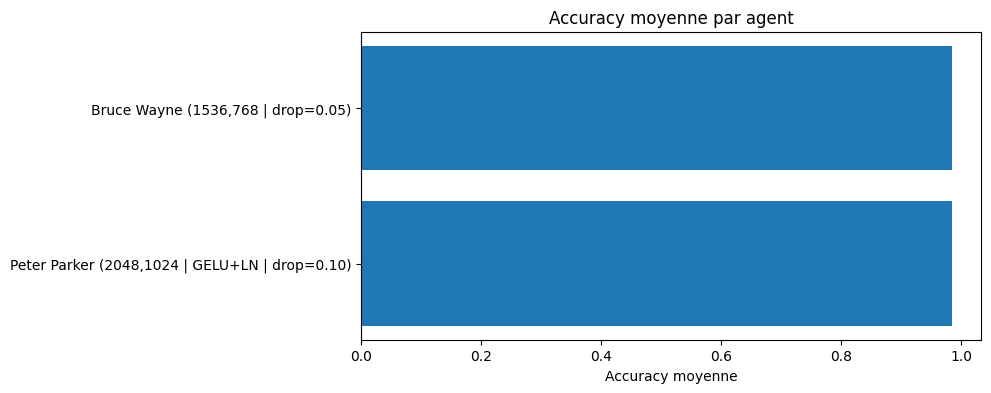

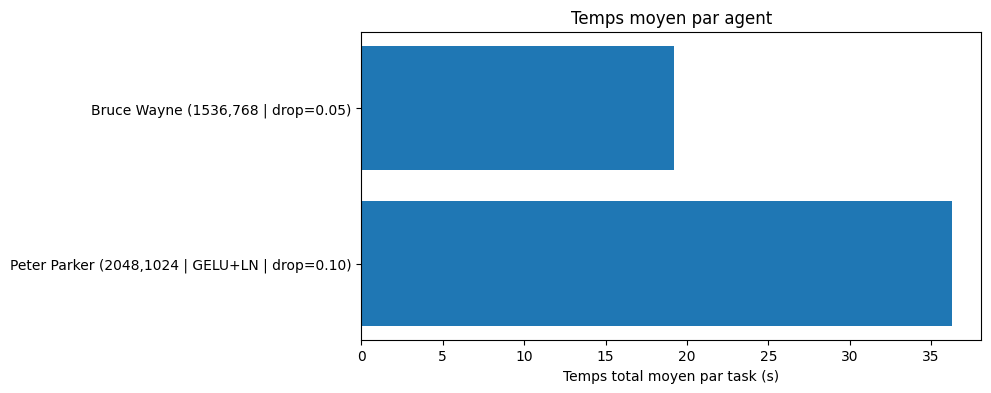

In [ ]:
#1er version qui marche mais qui est aps ouf sah 
# # =========================
# 0) Setup & env limits
# =========================
import os, sys, time, json, csv, re
from pathlib import Path
import importlib
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent        # notebook is in permuted_mnist/notebooks/
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from permuted_mnist.limits_perf3 import apply_challenge_limits, print_limits
apply_challenge_limits(threads=2, forbid_gpu=True, ram_gb=4, show=True)
print_limits()

from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

OUT_DIR = (ROOT / "experiments" / "benchmark_agents"); OUT_DIR.mkdir(parents=True, exist_ok=True)
SEED = 42
np.random.seed(SEED)

# =========================================
# 1) Déclarer les AGENTS DÉJÀ EXISTANTS
#    (module = 'permuted_mnist.agent_r1.<fichier_sans_.py>', cls = 'Agent')
# =========================================
AGENTS = [
    {
        "name": "Bruce Wayne (1536,768 | drop=0.05)",
        "module": "permuted_mnist.agent.mlp4.agent_Bruce_Wayne",
        "cls": "Agent",
        "kwargs": {"output_dim": 10, "seed": SEED}
    },
    {
        "name": "Peter Parker (2048,1024 | GELU+LN | drop=0.10)",
        "module": "permuted_mnist.agent.mlp3.agent_Peter_Parker",
        "cls": "Agent",
        "kwargs": {"output_dim": 10, "seed": SEED}
    },
    # Tu peux en ajouter d'autres ici…
]

# =========================
# 2) Helpers d’évaluation
# =========================
def _slug(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9._-]+', '_', s)

def make_agent(spec: dict):
    mod = importlib.import_module(spec["module"])
    cls = getattr(mod, spec["cls"])
    kwargs = dict(spec.get("kwargs", {}))
    # Valeurs par défaut si absentes
    kwargs.setdefault("output_dim", 10)
    kwargs.setdefault("seed", SEED)
    return cls(**kwargs)

def run_one_task(env, agent, spec_name: str):
    """
    Exécute UNE task en chronométrant train/predict + accuracy.
    Instanciation non comptée (plateforme style) ; on fait reset() par task.
    """
    task = env.get_next_task()
    if task is None:
        return None

    agent.reset()  # nouveau modèle pour cette task

    t0 = time.time()
    t_train0 = time.time()
    agent.train(task["X_train"], task["y_train"])
    t_train = time.time() - t_train0

    t_pred0 = time.time()
    preds = agent.predict(task["X_test"])
    t_pred = time.time() - t_pred0

    t_total = time.time() - t0
    acc = float(env.evaluate(preds, task["y_test"]))

    return {
        "name": spec_name,
        "acc": acc,
        "t_train": t_train,
        "t_pred": t_pred,
        "t_total": t_total,
        "n_train": int(task["X_train"].shape[0]),
        "n_test":  int(task["X_test"].shape[0]),
    }

def eval_agent_over_tasks(spec: dict, n_tasks=10, tag="runA"):
    """
    Évalue un agent existant sur n tasks ; sauvegarde CSV (une ligne par task) et retourne un résumé.
    """
    env = PermutedMNISTEnv(number_episodes=n_tasks)
    env.set_seed(SEED)

    agent = make_agent(spec)  # instancié UNE fois (coût non compté dans t_total)
    rows = []
    for _ in range(n_tasks):
        r = run_one_task(env, agent, spec["name"])
        if r is None:
            break
        rows.append(r)

    # CSV par agent
    csv_path = OUT_DIR / f"{_slug(tag)}__{_slug(spec['name'])}.csv"
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["name","acc","t_train","t_pred","t_total","n_train","n_test"])
        for r in rows:
            w.writerow([r["name"], r["acc"], r["t_train"], r["t_pred"], r["t_total"], r["n_train"], r["n_test"]])

    accs   = np.array([r["acc"] for r in rows], float) if rows else np.array([], float)
    ttot   = np.array([r["t_total"] for r in rows], float) if rows else np.array([], float)
    ttrain = np.array([r["t_train"] for r in rows], float) if rows else np.array([], float)
    tpred  = np.array([r["t_pred"] for r in rows], float) if rows else np.array([], float)

    summary = dict(
        name=spec["name"],
        acc_mean=float(accs.mean()) if accs.size else 0.0,
        acc_std=float(accs.std()) if accs.size else 0.0,
        t_total_mean=float(ttot.mean()) if ttot.size else 0.0,
        t_total_max=float(ttot.max()) if ttot.size else 0.0,
        t_train_mean=float(ttrain.mean()) if ttrain.size else 0.0,
        t_pred_mean=float(tpred.mean()) if tpred.size else 0.0,
        n_tasks=len(rows),
        csv=str(csv_path),
    )
    return summary, rows

# =========================
# 3) Lancer la campagne
# =========================
N_TASKS = 10
RUN_TAG = "cmp_v1"

summaries = []
all_rows = {}
for spec in AGENTS:
    s, rows = eval_agent_over_tasks(spec, n_tasks=N_TASKS, tag=RUN_TAG)
    summaries.append(s)
    all_rows[spec["name"]] = rows
    print(f"[{spec['name']}] acc={s['acc_mean']:.4f}±{s['acc_std']:.4f} | "
          f"t_mean={s['t_total_mean']:.1f}s (max {s['t_total_max']:.1f}s) | "
          f"train {s['t_train_mean']:.1f}s / pred {s['t_pred_mean']:.2f}s | n={s['n_tasks']}")

# Sauvegarde globale
with open(OUT_DIR / f"{_slug(RUN_TAG)}__summaries.json","w") as f:
    json.dump(summaries, f, indent=2)

# =========================
# 4) Tableau synthèse + plots
# =========================
summaries = sorted(summaries, key=lambda d: (-d["acc_mean"], d["t_total_mean"]))
print("\n=== RANKING ===")
for i,s in enumerate(summaries,1):
    print(f"{i:>2}. {s['name']:<40}  acc {s['acc_mean']:.4f}±{s['acc_std']:.4f}  |  "
          f"Tmean {s['t_total_mean']:.1f}s (Tmax {s['t_total_max']:.1f}s)  |  "
          f"train {s['t_train_mean']:.1f}s / pred {s['t_pred_mean']:.2f}s  |  n={s['n_tasks']}")

# Plots (sans style/couleurs imposés)
names = [s["name"] for s in summaries]
accs  = [s["acc_mean"] for s in summaries]
tmean = [s["t_total_mean"] for s in summaries]

plt.figure(figsize=(8,4))
plt.barh(range(len(names)), accs)
plt.yticks(range(len(names)), names)
plt.xlabel("Accuracy moyenne")
plt.title("Accuracy moyenne par agent")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8,4))
plt.barh(range(len(names)), tmean)
plt.yticks(range(len(names)), names)
plt.xlabel("Temps total moyen par task (s)")
plt.title("Temps moyen par agent")
plt.gca().invert_yaxis()
plt.show()